# Training and Test sets

We have seen how detrimental overfitting can be to predictive models. Models biased for the sample they were fitted (trained) on might not capture much form the underlying true relationship.
The next step is to evaluate, how much predictive performance we have when we rule out the effect of overfitting.
There is a very straightforward solution: we can simply obtain predictions with our fitted model on data that it haven't seen before.

Below, we re-compute two models that we have fitted in the previous section and obtain more data that the models haven't seen before and use it for testing their *unbiased* predictive performance.

Let's install and import some libraries.
Here we start using a new package> `scikit-learn`.

```{note}
[Scikit-learn](https://scikit-learn.org/stable/) is the leading package for "classical" machine learning, with an excellent documentation and a very active community.
It offers a great start into predictive modelling and machine learning for people with a broad spectrum of background.
```

In [4]:
!pip install scikit-learn
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression

You should consider upgrading via the '/home/tspisak/src/RPN-signature/venv/bin/python -m pip install --upgrade pip' command.


Now we load our example dataset, but in two non-overlapping pieces. The first 80 participants are loaded into `df_train`. Then, another 80 are loaded into `df_test`.

In [98]:
df = pd.read_csv("https://raw.githubusercontent.com/pni-lab/predmod_lecture/master/ex_data/IXI/ixi.csv")
train = df.index[:80]
test = df.index[80:160]
features = df.columns[2:]
target = 'Age'

## Train overfitted models

First, we fit a linear model called `model_1`, with one single predictor, the right superior frontal cortex volume.

This time we use `scikit-learn`'s implementation of linear regression (instead of the `statsmodels`' function).
`Scikit-learn`'s `LinearRegression()` is a minimalistic implementation that is, in many ways, optimized for use in machine learning.
It doesn't even provide p-values. But we won't miss them...

Note that we use only the "training sample" (`df.loc[train, target]`) to fit the model.

```{seealso}
Wonder, what `.loc` means in the code? It's just the syntax for dataframe indexing/slicing in 2-dimensions (rows and columns). See the pandas [documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html) for more detail.
```

MAE: 12.7710554136974


<AxesSubplot:xlabel='Age'>

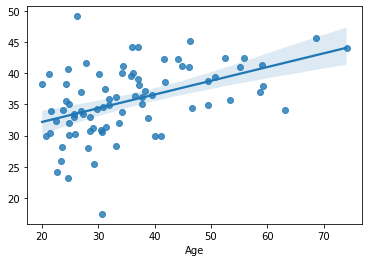

In [99]:
model_1 = LinearRegression().fit(y=df.loc[train, target], X=df.loc[train, ['rh_superiorfrontal_volume']])
yhat = model_1.predict(df.loc[train, ['rh_superiorfrontal_volume']])
mae_model_1_train = np.mean(np.abs(df.loc[test, target] - yhat))
print('MAE:', mae_model_1_train)
sns.regplot(x=df.loc[train, target], y=yhat)

We have computed a simple measure of how much the model predictions differ form the actual data: the mean absolute error (MAE):

$$
MAE = \sum|y - \hat{y}|
$$

Now, we train `model_2`, which takes use of **all** available predictors.

MAE: 3.2574285440159656


<AxesSubplot:xlabel='Age'>

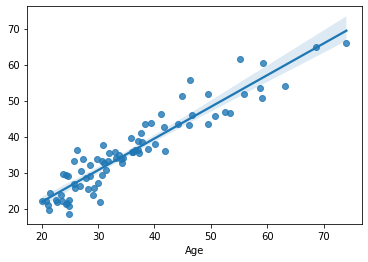

In [100]:
model_2 = LinearRegression().fit(y=df.loc[train, target], X=df.loc[train, features])
yhat = model_2.predict(df.loc[train, features])
mae_model_2_train = np.mean(np.abs(df.loc[train, target] - yhat))
print('MAE:', mae_model_2_train)
sns.regplot(x=df.loc[train, target], y=yhat)

Finally, we train `model_3`, a dummy model with random features that are guaranteed to be independent form the target.

MAE: 3.9538865240948704


<AxesSubplot:xlabel='Age'>

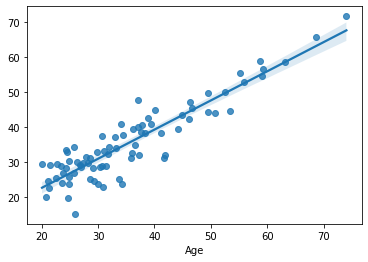

In [101]:
rng = np.random.default_rng(seed = 42)
df_random = pd.DataFrame(rng.normal(loc=np.mean(df.loc[train, features]), scale=np.std(df.loc[train, features]), size=(len(train), len(features))))
model_3 = LinearRegression().fit(y=df.loc[train, target], X=df_random)
yhat = model_3.predict(df_random)
mae_model_3_train = np.mean(np.abs(df.loc[train, target] - yhat))
print('MAE:', mae_model_3_train)
sns.regplot(x=df.loc[train, target], y=yhat)

We see the same picture as in the previous section: adding more predictors increases performance on the training set, even if the predictors are just random noise.
We also already know that this is due to overfitting the training set.

But how much do these models overfit?
Here comes the moment if justice!

## Test overfitted models on unseen data

Let's test all models on the test set, i.e. on data that the model haven't seen during training.

MAE: 10.51406018565751


<AxesSubplot:xlabel='Age'>

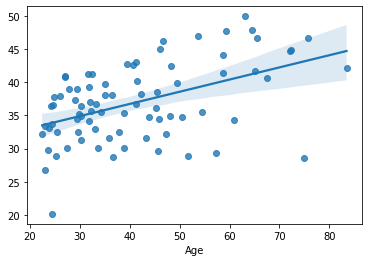

In [102]:
yhat = model_1.predict(df.loc[test, ['rh_superiorfrontal_volume']])
mae_model_1_test = np.mean(np.abs(df.loc[test, target] - yhat))
print('MAE:', mae_model_1_test)
sns.regplot(x=df.loc[test, target], y=yhat)

MAE: 14.418876799838511


<AxesSubplot:xlabel='Age'>

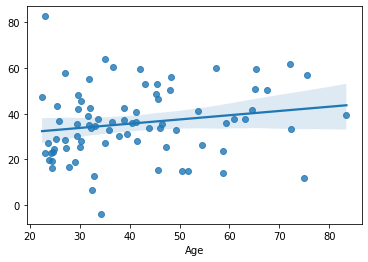

In [103]:
yhat = model_2.predict(df.loc[test, features])
mae_model_2_test = np.mean(np.abs(df.loc[test, target] - yhat))
print('MAE:', mae_model_2_test)
sns.regplot(x=df.loc[test, target], y=yhat)

MAE: 24.69969184046377


<AxesSubplot:xlabel='Age'>

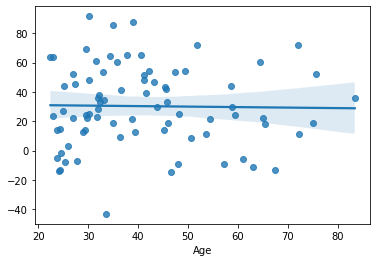

In [104]:
yhat = model_3.predict(df.loc[test, features])
mae_model_3_test = np.mean(np.abs(df.loc[train, target] - yhat))
print('MAE:', mae_model_3_test)
sns.regplot(x=df.loc[test, target], y=yhat)

Let's summarise the results!

<AxesSubplot:xlabel='model', ylabel='MAE'>

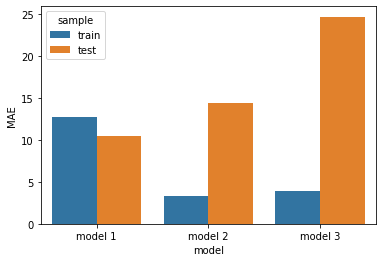

In [105]:
summary = pd.DataFrame([[mae_model_1_train, 'model 1', 'train'],
                        [mae_model_1_test, 'model 1', 'test'],
                        [mae_model_2_train, 'model 2', 'train'],
                        [mae_model_2_test, 'model 2', 'test'],
                        [mae_model_3_train, 'model 3', 'train'],
                        [mae_model_3_test, 'model 3', 'test']], columns=['MAE', 'model', 'sample'])

sns.barplot(x='model', y='MAE', hue='sample', data=summary)

What we see that performance on the training and test sets can be strikingly different.
The simplest model (`model_1`) with a single predictor performed best on the test set, actually even slightly better (lower error) than on the training set, implying a negligible level of overfitting in case of this model.
The other two models were much more complex, i.e. they had a lot more parameters to (over)fit. Indeed, while they seemed to perform significantly better than `model_1` on the trainig set, their performance strikingly dropped on the test set. These models heavily overfitted the training data.

Even though it overfitted the training sample, `model_2` has captured some generalizable knowledge, as well. On the other hand, our pure-noise model (`model_3`), as expected, didn't perform better than chance on the test set and all its performance on the training set has to be attributed to overfitting.

:::{admonition} Excercise 3.3
:class: tip, dropdown
Does a simple linear model overfit with your own dataset, too?
Try it out in Google Colab!
:::

## Train-test split

Holding out a test set (or measuring new data post model training) is a very common practice in predictive modelling and machine learning, providing a very straightforward solution for ruling out the effect of overfitting and  to obtain unbiased estimates of predictive performance.

However, due to the costs of the data acquisition, holding out a large number of participants solely for testing is often a luxury.
In the [next section](cv.ipynb) we will see, how cross-validation can help in getting out the most of our data when training predictive models.